In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crimes-in-chicago/Chicago_Crimes_2008_to_2011.csv
/kaggle/input/crimes-in-chicago/Chicago_Crimes_2012_to_2017.csv
/kaggle/input/crimes-in-chicago/Chicago_Crimes_2001_to_2004.csv
/kaggle/input/crimes-in-chicago/Chicago_Crimes_2005_to_2007.csv


In [1]:
# Importing libraries

import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet 

In [13]:
# Load data

chicago_df_1 =  pd.read_csv("../input/crimes-in-chicago/Chicago_Crimes_2005_to_2007.csv",error_bad_lines=False)
chicago_df_2 =  pd.read_csv("../input/crimes-in-chicago/Chicago_Crimes_2008_to_2011.csv",error_bad_lines=False)
chicago_df_3 =  pd.read_csv("../input/crimes-in-chicago/Chicago_Crimes_2012_to_2017.csv",error_bad_lines=False)

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [14]:
# Concatenating data

chicago_df = pd.concat([chicago_df_1,chicago_df_2,chicago_df_3])

In [15]:
chicago_df.shape

(6017767, 23)

In [18]:
# Exploring data

chicago_df.head(3)


,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"


In [19]:
chicago_df.tail(2)

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1456712,6253257,10508690,HZ250370,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,...,7.0,46.0,08B,1197261.0,1850727.0,2016,05/10/2016 03:56:50 PM,41.745252,-87.552773,"(41.745251975, -87.552773464)"
1456713,6253474,10508692,HZ250517,05/03/2016 11:38:00 PM,001XX E 75TH ST,5007,OTHER OFFENSE,OTHER WEAPONS VIOLATION,PARKING LOT/GARAGE(NON.RESID.),True,...,6.0,69.0,26,1178696.0,1855324.0,2016,05/10/2016 03:56:50 PM,41.758309,-87.620658,"(41.75830866, -87.620658418)"


Observation - Chicago crime dataset is unordered time stamped data 

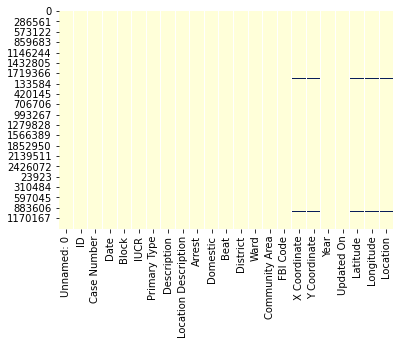

In [20]:
# Check for missing data

sns.heatmap(chicago_df.isnull() , cbar=False , cmap='YlGnBu')

In [21]:
# Dropping missing data

chicago_df.drop(['Unnamed: 0','Case Number','ID','IUCR','X Coordinate','Y Coordinate','Updated On','Year','FBI Code','Beat','Ward'
                ,'Community Area','Location','District','Latitude','Longitude'] , axis=1 , inplace=True)

In [22]:
chicago_df.shape

(6017767, 7)

In [25]:
# Converting date column into datetime object

chicago_df['Date'] = pd.to_datetime(chicago_df['Date'] , format='%m/%d/%Y %I:%M:%S %p')
chicago_df.head(2)

,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False


In [32]:
chicago_df.index = pd.DatetimeIndex(chicago_df['Date'])

In [33]:
chicago_df.head(2)

,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
Date,,,,,,,
2006-04-02 13:00:00,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
2006-02-26 13:40:48,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False


In [29]:
# What are top 15 charges ?

Order = chicago_df['Primary Type'].value_counts().iloc[:15].index

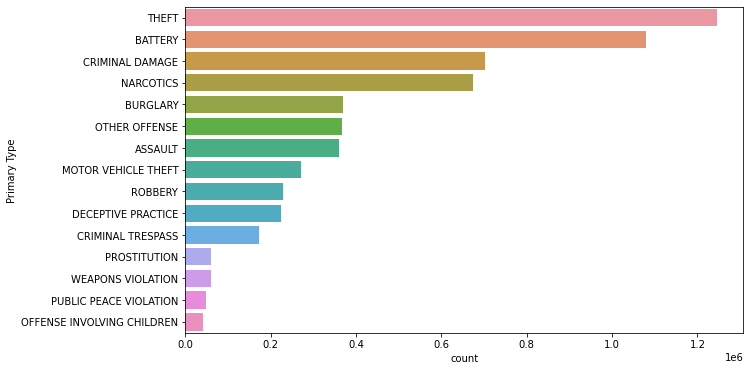

In [30]:
plt.figure(figsize=(10,6))
sns.countplot(y = 'Primary Type' , data = chicago_df , order=Order)

Observation : THEFT is most frequent crime occuring in chicago based on data. 


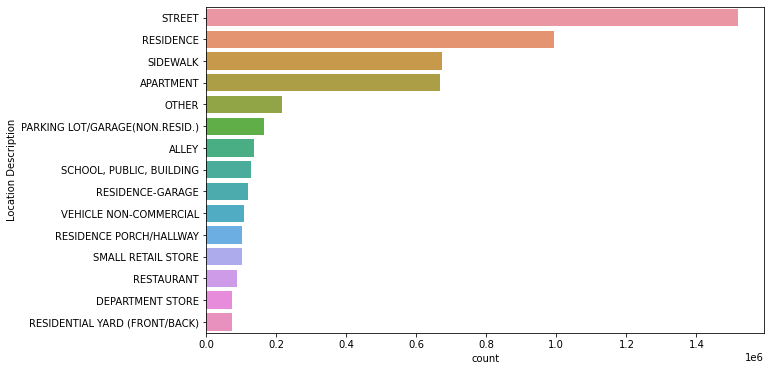

In [31]:
#  Number of violations occured  on different Locations 

plt.figure(figsize=(10,6))

sns.countplot(y = 'Location Description' , data= chicago_df , order=chicago_df['Location Description'].value_counts().iloc[:15].index)

Observation - Most of crimes occur on streets, based on data.

In [34]:
# How many crimes occured in a specific year ?

chicago_df.resample('Y').size()

Date
2005-12-31    455811
2006-12-31    794684
2007-12-31    621848
2008-12-31    852053
2009-12-31    783900
2010-12-31    700691
2011-12-31    352066
2012-12-31    335670
2013-12-31    306703
2014-12-31    274527
2015-12-31    262995
2016-12-31    265462
2017-12-31     11357
Freq: A-DEC, dtype: int64

Text(0, 0.5, '# crimes ')

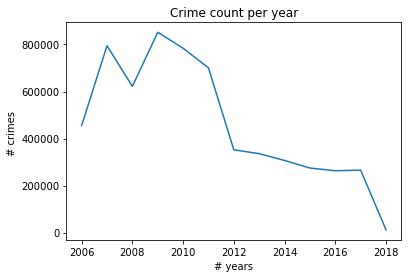

In [35]:
plt.plot(chicago_df.resample('Y').size())
plt.title('Crime count per year')
plt.xlabel('# years')
plt.ylabel('# crimes ')

Observation - Number of crimes were decreased over years. It was low in 2018.

Text(0, 0.5, '# crimes ')

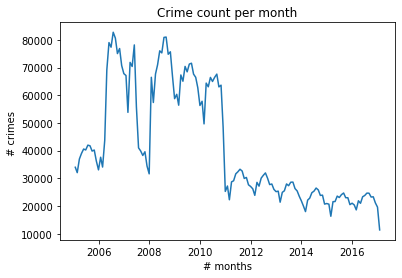

In [37]:
# How many crimes occured in a specific month ?

plt.plot(chicago_df.resample('M').size())
plt.title('Crime count per month')
plt.xlabel('# months')
plt.ylabel('# crimes ')

Observation - There is a seasonal trend in crime occurences. Overall trend is down

Text(0, 0.5, '# crimes ')

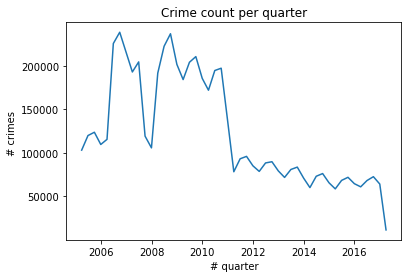

In [38]:
# How many crimes occured in a quarter ?

plt.plot(chicago_df.resample('Q').size())
plt.title('Crime count per quarter')
plt.xlabel('# quarter')
plt.ylabel('# crimes ')

In [41]:
# Prepare the data - Resampling the data by month

chicago_prophet = chicago_df.resample('M').size().reset_index()
chicago_prophet.columns = ['ds' , 'y']  # Inorder to apply facebook prophet , we need to assign date column as "ds" and # counts column as "y". 
chicago_prophet

,ds,y
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572
...,...,...
140,2016-09-30,23235
141,2016-10-31,23314
142,2016-11-30,21140
143,2016-12-31,19580


In [42]:
# Applying Prophet 

m = Prophet()

m.fit(chicago_prophet)

In [43]:
# Predictions

future = m.make_future_dataframe(periods=365)  # Creating a dataframe with future dates (for 1 year) for forecasting.
forecast = m.predict(future)

In [47]:
future

,ds
0,2005-01-31
1,2005-02-28
2,2005-03-31
3,2005-04-30
4,2005-05-31
...,...
505,2018-01-27
506,2018-01-28
507,2018-01-29
508,2018-01-30


In [44]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-31,60454.736755,39018.989055,73778.006195,60454.736755,60454.736755,-4762.400048,-4762.400048,-4762.400048,-4762.400048,-4762.400048,-4762.400048,0.0,0.0,0.0,55692.336707
1,2005-02-28,60322.333828,35316.987091,66963.437307,60322.333828,60322.333828,-9500.508891,-9500.508891,-9500.508891,-9500.508891,-9500.508891,-9500.508891,0.0,0.0,0.0,50821.824937
2,2005-03-31,60175.744873,41521.861948,74997.479517,60175.744873,60175.744873,-1224.148242,-1224.148242,-1224.148242,-1224.148242,-1224.148242,-1224.148242,0.0,0.0,0.0,58951.596630
3,2005-04-30,60033.884593,44814.263344,79241.018577,60033.884593,60033.884593,1182.830385,1182.830385,1182.830385,1182.830385,1182.830385,1182.830385,0.0,0.0,0.0,61216.714978
4,2005-05-31,59887.295638,49759.690169,82418.827715,59887.295638,59887.295638,5498.250108,5498.250108,5498.250108,5498.250108,5498.250108,5498.250108,0.0,0.0,0.0,65385.545746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,2018-01-27,10104.041516,-10392.480382,22539.457108,9966.664752,10267.630394,-4977.963003,-4977.963003,-4977.963003,-4977.963003,-4977.963003,-4977.963003,0.0,0.0,0.0,5126.078513
506,2018-01-28,10090.974833,-10966.868341,22101.144393,9952.538033,10255.444762,-4922.604059,-4922.604059,-4922.604059,-4922.604059,-4922.604059,-4922.604059,0.0,0.0,0.0,5168.370774
507,2018-01-29,10077.908150,-11330.370308,22619.452956,9938.411315,10243.180383,-4867.916431,-4867.916431,-4867.916431,-4867.916431,-4867.916431,-4867.916431,0.0,0.0,0.0,5209.991719
508,2018-01-30,10064.841467,-10503.424111,23196.705786,9924.284597,10230.680203,-4816.731916,-4816.731916,-4816.731916,-4816.731916,-4816.731916,-4816.731916,0.0,0.0,0.0,5248.109550


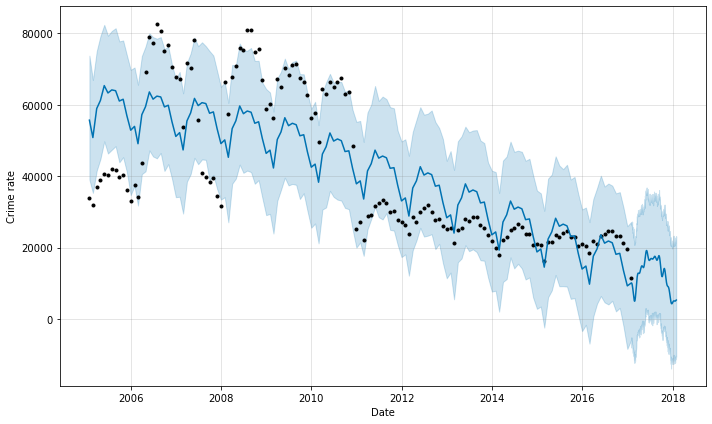

In [45]:
# Visualising crime rate predictions

figure = m.plot(forecast,xlabel='Date',ylabel='Crime rate')

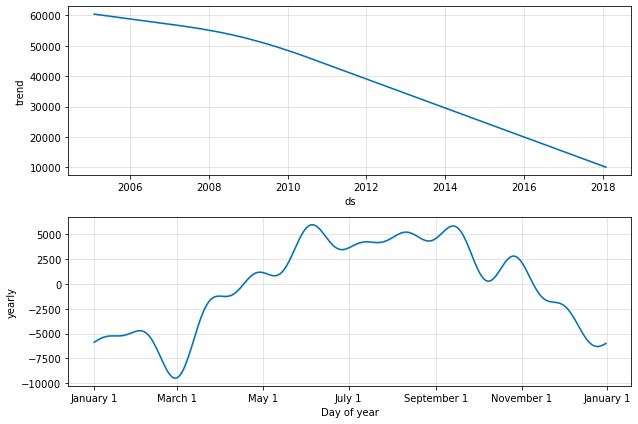

In [46]:
# Checking all components of time series data

figure = m.plot_components(forecast)

Observation:
* Crime rate is high from march every year.
* Overall trend is down.